In [1]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
import metpy.calc as mpcalc
from metpy.units import units
from scipy import stats

# Import my modules
sys.path.append('../modules') # Path to modules
from constants import ucsd_colors
from plotter import SeabornFig2Grid as sfg
from preprocess_dataframes import combine_ivt_ar_prec_df, df_annual_clim, calculate_ivt_prec_percentiles, df_AR_annual_clim

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [2]:
path_to_data = '/home/dnash/SEAK_clim_data/' 
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## open precipitation and ivt dfs
## append precip to each community IVT df
option = 'a'
temporal_res = 'daily'
community_lst = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']

df_lst = combine_ivt_ar_prec_df(option, temporal_res, community_lst) # combine dfs into list of dfs
prec_clim, prec_std = df_annual_clim(df_lst, community_lst, varname='prec') # get precipitation annual climatology
ivt_clim, ivt_std = df_annual_clim(df_lst, community_lst, varname='IVT') # get IVT annual climatology

prec_percentile, ivt_percentile = calculate_ivt_prec_percentiles(df_lst, community_lst) # get dataframe of percentiles

# some cleaning for the dfs for the annual clim fig
prec_clim['month'] = prec_clim.index.values - 1
prec_melt = pd.melt(prec_clim, id_vars='month')

ivt_clim['month'] = ivt_clim.index.values - 1
ivt_melt = pd.melt(ivt_clim, id_vars='month')

ar_clim = df_AR_annual_clim(df_lst, community_lst, varname='AR') # get AR annual climatology

<AxesSubplot:xlabel='time'>

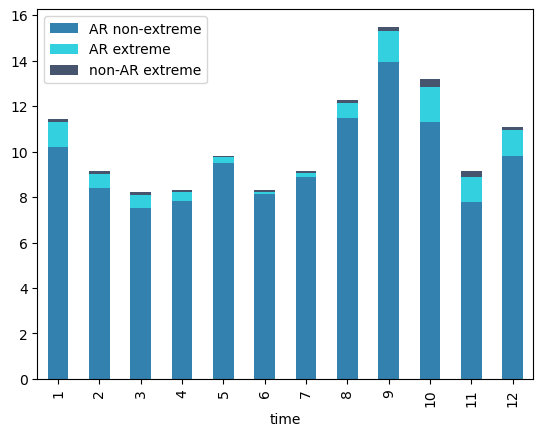

In [4]:
ar_clim.plot(kind = 'bar', stacked = True, color=[ucsd_colors['blue'], ucsd_colors['aqua'], ucsd_colors['navy']], alpha=0.8)

<AxesSubplot:>

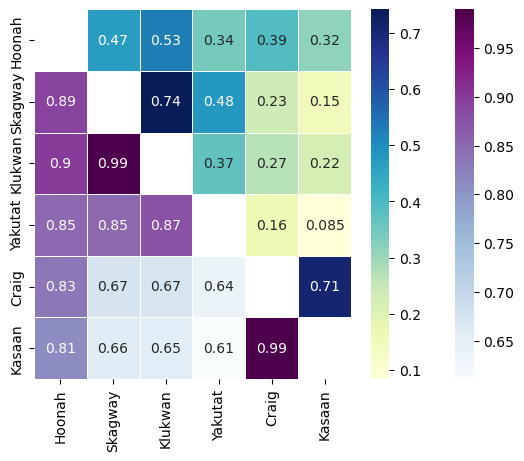

In [5]:
## create correlation table
ivt_corr = ivt_percentile.corr('pearson')
prec_corr = prec_percentile.corr('pearson')

matrix_0 = np.triu(ivt_corr)
matrix_1 = np.tril(prec_corr)

sns.heatmap(ivt_corr,annot=True,mask=matrix_0,cmap="BuPu", linewidth=.5, xticklabels=community_lst, yticklabels=community_lst)
sns.heatmap(prec_corr,annot=True,mask=matrix_1,cmap="YlGnBu", linewidth=.5, xticklabels=community_lst, yticklabels=community_lst)

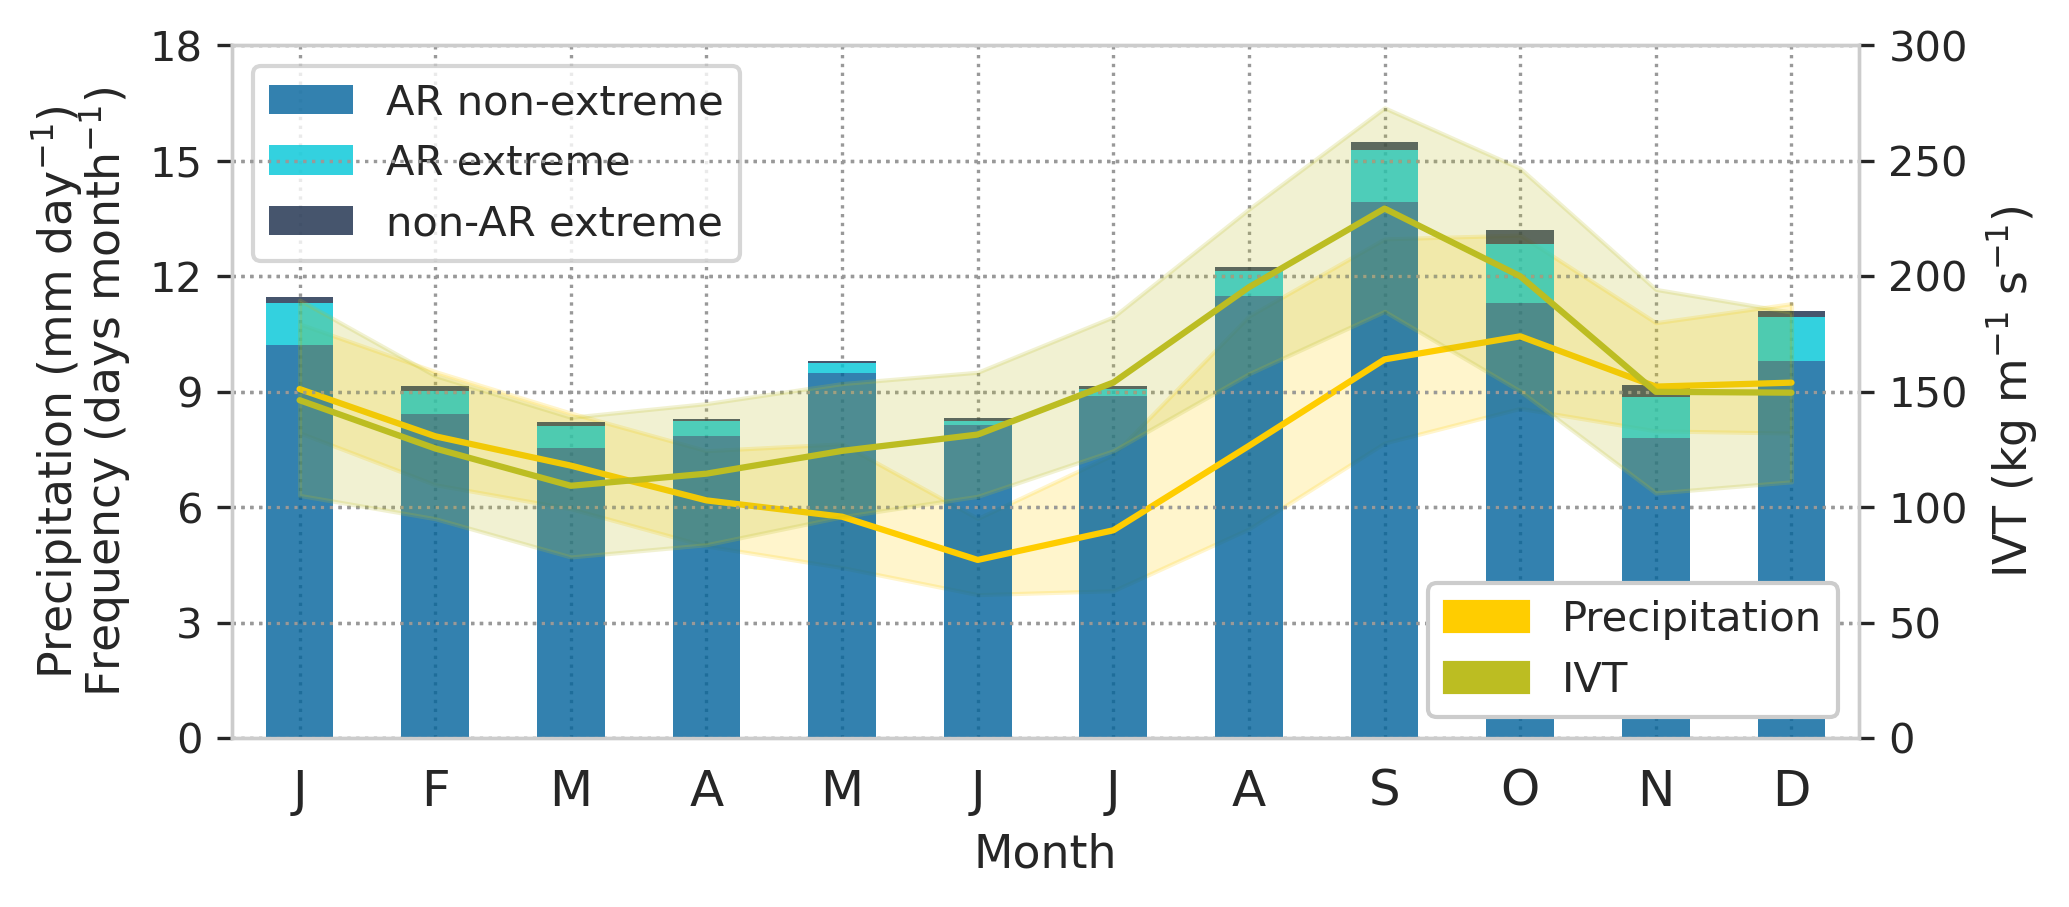

In [15]:
fname = path_to_figs + 'ar_barplot'
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((7.0,3.0))
fig.dpi = 300
nplots=1

# Set custom color palette
colors = ["#00629B"]
sns.set_palette(sns.color_palette(colors))
columns=['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
          
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})
# sns.set_context("paper")
sns.despine()

for i in np.arange(nplots):
    ax = fig.add_subplot(1, 1, i+1)
    ## bar plot with AR clim
    ar_clim.plot(kind = 'bar', stacked = True, color=[ucsd_colors['blue'], ucsd_colors['aqua'], ucsd_colors['navy']], 
                 alpha=0.8, zorder=10, ax=ax, rot='horizontal', legend=False, linewidth=0.)
    ax.set_ylabel('Frequency (days month$^{-1}$)', fontsize=11)
    ax.set_xlabel('Month', fontsize=11)
    ax.set_xticklabels(columns, fontsize=12)
    ax.set_yticks(np.arange(0, 21, 3))
    ax.set_ylim(0, 18)
    
    ## line plot with precip clim
    # sns.lineplot(data=prec_melt, x="month", y="value", hue="variable", palette="flare", ax=ax) # plots all communities individually
    sns.lineplot(data=prec_melt, x="month", y="value", ax=ax, color=ucsd_colors['yellow'], zorder=101) # plots community spread
    
    # Add secondary ylabel to first axis
    ax.text(-0.09, 0.5, 'Precipitation (mm day$^{-1}$)', va='bottom', ha='center', 
            rotation='vertical', rotation_mode='anchor', fontsize=11, 
            transform=ax.transAxes)


    ## add twin axis for ivt
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    # sns.lineplot(data=ivt_melt, x="month", y="value", hue="variable", palette="flare", ax=ax2) # plots all communities individually
    sns.lineplot(data=ivt_melt, x="month", y="value", ax=ax2, color='tab:olive', zorder=100) # plots community spread
    ax2.set_yticks(np.arange(0, 325, 50))
    ax2.set_ylim(0, 300)
    ax2.set_ylabel('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
    
    # ax.set_axisbelow(True)
    # ax2.set_axisbelow(True)
    
    # create legend (of the 3 classes)
    # patch0 = mpatches.Patch(color=ucsd_colors['navy'], label='Non-extreme AR')
    # patch1 = mpatches.Patch(color=ucsd_colors['blue'], label='Extreme AR')
    # patch2 = mpatches.Patch(color=ucsd_colors['aqua'], label='Extreme non-AR')
    patch3 = mpatches.Patch(color=ucsd_colors['yellow'], label='Precipitation')
    patch4 = mpatches.Patch(color='tab:olive', label='IVT')
    ax2.legend(handles=[patch3,patch4], loc='lower right', framealpha=1.0).set_zorder(200)
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
plt.show()

In [17]:
df = df_lst[0] # just get Hoonah
idx = (df.index.year == 1980)
df = df.loc[idx]
df

,time,IVT,lat,lon,uIVT,vIVT,IWV,ivtdir,AR,impact,prec,prec_Hoonah,ivt_Hoonah
time,,,,,,,,,,,,,
1980-01-01,1980-01-01,148.93,58.00,-135.50,29.62,148.30,11.56,211.02,0,0,6.35,0.61,0.58
1980-01-02,1980-01-02,147.08,58.00,-135.50,6.58,146.94,11.51,186.81,0,0,10.58,0.77,0.57
1980-01-03,1980-01-03,101.50,58.00,-135.50,26.70,101.25,10.91,257.80,0,0,20.42,0.93,0.40
1980-01-04,1980-01-04,29.98,58.00,-135.50,21.53,3.76,5.02,357.52,0,0,0.19,0.06,0.06
1980-01-05,1980-01-05,207.19,58.00,-135.50,200.70,-24.81,10.29,343.00,1,0,NaN,NaN,0.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980-12-27,1980-12-27,52.58,58.00,-135.50,49.19,22.37,8.14,351.33,1,0,0.20,0.06,0.16
1980-12-28,1980-12-28,166.64,58.00,-135.50,50.36,166.27,13.25,240.00,1,0,6.45,0.62,0.63
1980-12-29,1980-12-29,199.99,58.00,-135.50,83.32,199.97,15.56,213.36,1,0,16.09,0.88,0.72


In [18]:
# create a column that shows what the fraction to total annual precip is
annual = df['prec'].sum()
df['frac_annual'] = (df['prec']/annual)*100
df['cum_prec'] = df['frac_annual'].cumsum()
df


/tmp/ipykernel_122090/3100093557.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['frac_annual'] = (df['prec']/annual)*100
/tmp/ipykernel_122090/3100093557.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cum_prec'] = df['frac_annual'].cumsum()


,time,IVT,lat,lon,uIVT,vIVT,IWV,ivtdir,AR,impact,prec,prec_Hoonah,ivt_Hoonah,frac_annual,cum_prec
time,,,,,,,,,,,,,,,
1980-01-01,1980-01-01,148.93,58.00,-135.50,29.62,148.30,11.56,211.02,0,0,6.35,0.61,0.58,0.41,0.41
1980-01-02,1980-01-02,147.08,58.00,-135.50,6.58,146.94,11.51,186.81,0,0,10.58,0.77,0.57,0.69,1.10
1980-01-03,1980-01-03,101.50,58.00,-135.50,26.70,101.25,10.91,257.80,0,0,20.42,0.93,0.40,1.33,2.44
1980-01-04,1980-01-04,29.98,58.00,-135.50,21.53,3.76,5.02,357.52,0,0,0.19,0.06,0.06,0.01,2.45
1980-01-05,1980-01-05,207.19,58.00,-135.50,200.70,-24.81,10.29,343.00,1,0,NaN,NaN,0.73,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980-12-27,1980-12-27,52.58,58.00,-135.50,49.19,22.37,8.14,351.33,1,0,0.20,0.06,0.16,0.01,98.32
1980-12-28,1980-12-28,166.64,58.00,-135.50,50.36,166.27,13.25,240.00,1,0,6.45,0.62,0.63,0.42,98.74
1980-12-29,1980-12-29,199.99,58.00,-135.50,83.32,199.97,15.56,213.36,1,0,16.09,0.88,0.72,1.05,99.79


/home/dnash/miniconda3/envs/SEAK-clim/lib/python3.10/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<AxesSubplot:xlabel='prec_Hoonah', ylabel='Count'>

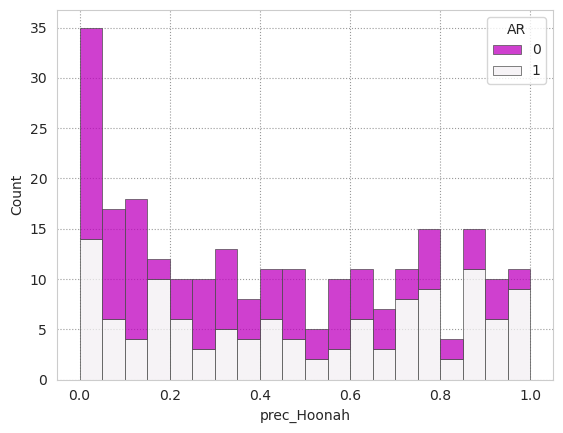

In [19]:
bins = np.arange(0., 1.05, 0.05)

sns.histplot(df, x="prec_Hoonah", hue="AR",
             multiple="stack",
             palette="light:m_r",
             edgecolor=".3",
             linewidth=.5,
             bins=bins)

<AxesSubplot:xlabel='time'>

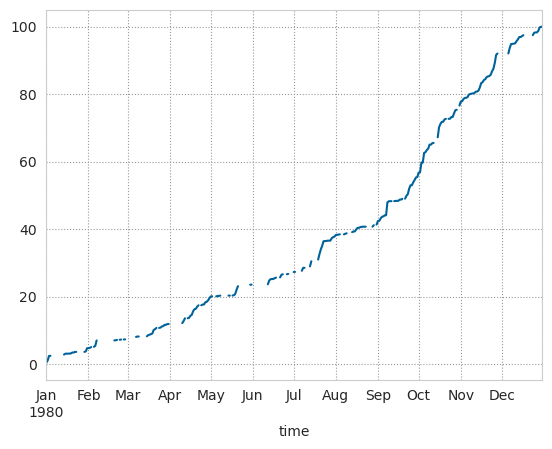

In [20]:
df.cum_prec.plot()

<AxesSubplot:xlabel='time'>

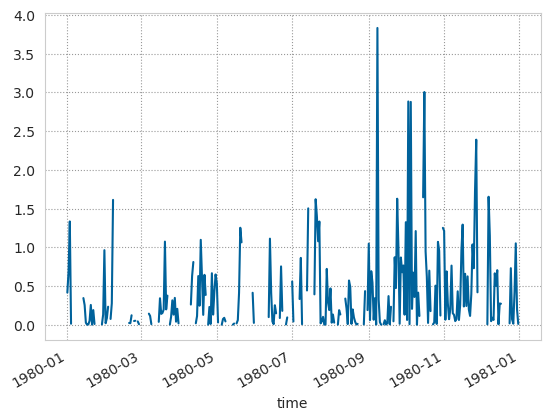

In [21]:
## sort the fraction of annual precip 
test = df['frac_annual'].sort_values()
test.plot()

In [22]:
prec_thres = df['prec'].describe(percentiles=[.95]).loc['95%'] # 95th percentile precipitation threshold
df.query("prec > {0}".format(prec_thres)).shape[0]

13

In [26]:
final_df_lst = []
## some information on AR contribution
for i, df_tmp in enumerate(df_lst):
    prec_thres = df_tmp['prec'].describe(percentiles=[.95]).loc['95%'] # 95th percentile precipitation threshold
    
    summary_df = pd.DataFrame(columns=['# prec days', '# AR days (non-extreme)', '# extreme prec days','# extreme AR days',
                                       'total annual prec', 'total AR prec (non-extreme)', 'total extreme prec', 'total extreme AR prec'], index=range(1980, 2020))
    
    for j, yr in enumerate(range(1980, 2020)):
        idx = (df_tmp.index.year == yr)
        df = df_tmp.loc[idx]
        # number of days per year with precipitation > 0.1
        total_count = df.shape[0]
        calm_count = df.query("prec < 0.1").shape[0]
        x = (total_count - calm_count) # number of days with precipitation greater than 0.1 mm per day
        
        # number of AR days per year
        idx = (df.AR == 1) & (df.prec > 0.1) & (df.prec < prec_thres)
        ar_days = len(df.loc[idx]) # number of AR days per year
        ar_prec_clim = df.loc[idx].prec.sum() # get total precipitation per year during non-extreme ARs
    
        # AR contribution to total annual precipitation
        ## (total annual precip during AR days / total annual precip) * 100
        prec_clim = df.prec.sum() # get total precipitation per year
        
        # number of days per year where precipitation is "extreme" > 95th percentile
        extreme_count = df.query("prec > {0}".format(prec_thres)).shape[0]
    
        ## number of AR days with extreme precipitation
        idx = (df.AR == 1) & (df.prec > prec_thres)
        ar_days_extreme  = len(df.loc[idx]) # days
        ar_prec_clim_extreme = df.loc[idx].prec.sum() # amount of precip
    
        ## AR contribution to extreme precipitation
        ## (total annual precip during extreme AR days / total annual precip during extreme precip) * 100
        extreme_prec_clim = df.loc[(df.prec > prec_thres)].prec.sum()
        ar_contr_extreme = (ar_prec_clim_extreme / extreme_prec_clim) *100
        
        summary_df.loc[yr] = pd.Series({'# prec days': x,
                                        '# AR days (non-extreme)': ar_days,
                                        '# extreme prec days': extreme_count,
                                        '# extreme AR days': ar_days_extreme,
                                        'total annual prec': prec_clim,
                                        'total AR prec (non-extreme)': ar_prec_clim,
                                        'total extreme prec': extreme_prec_clim, 
                                        'total extreme AR prec': ar_prec_clim_extreme})
        
        summary = summary_df.mean() # average all years
    final_df_lst.append(summary)
    

df_concat = pd.concat(final_df_lst)

In [28]:
final_df_lst[0]

# prec days                     357.48
# AR days (non-extreme)          88.20
# extreme prec days              11.47
# extreme AR days                 9.95
total annual prec             1,656.70
total AR prec (non-extreme)     690.21
total extreme prec              382.48
total extreme AR prec           332.10
dtype: float64

In [ ]:
a = ((340 - 11)/340)*100 # total number of non-AR, non-extreme precip days
b = ((340 - 102.00)/340)*100 # total number of AR, non-extreme precip days
c = (9/340)*100 # total number of AR extreme precip days
d = ((11 - 9)/340)*100 # total number of non-AR extreme precip days
print(a, b, c, d)
lblin = ['{0} days'.format(340 - 11), 
         '{0} days'.format(340-102), 
         '{0} days'.format(9),
         '{0} days'.format(11-9)]

A = ((1531.78 - 380.82)/1531.78)*100 # total non-AR non-extreme precip
B = ((1531.78 - 662.18)/1531.78)*100 # total AR, non-extreme precip
C = (331.08/1531.78)*100 # total AR extreme precip
D = ((380.82 - 331.08)/1531.78)*100 # total non-AR extreme precip
lblout = ['{0} mm'.format(round(1531.78 - 380.82)), 
          '{0} mm'.format(round(1531.78 - 662.18)), 
          '{0} mm'.format(round(331.08)), 
          '{0} mm'.format(round(380.82 - 331.08))]
print(A, B, C, D)

In [ ]:
fig, ax = plt.subplots()
ax.axis('equal')
width = 0.3

cm = plt.get_cmap("tab20c")
cout = cm(np.arange(4)*4)

pie, _ = ax.pie([A,B,C, D], radius=1, labels=lblout, colors=cout)
plt.setp( pie, width=width, edgecolor='white')

cin = cm(np.array([1,5,9]))

# labels = list(map("".join, zip(list("abc"),map(str, [1,2]*3))))
pie2, _ = ax.pie([a,b,c,d], radius=1-width, labels=lblin,
                                      labeldistance=0.3, colors=cin)
plt.setp( pie2, width=width, edgecolor='white')
plt.show()

In [ ]:
idx = (df['prec'] > prec_thres)
tmp = df.loc[idx]
tmp.prec.sum()

In [ ]:
## some information on AR contribution
for i, df in enumerate(df_lst):
    print('On average in {0}...'.format(community_lst[i]))
    # number of days per year with precipitation > 0.1
    total_count = df.shape[0]
    calm_count = df.query("prec < 0.1").shape[0]
    # print('Of {} total observations, {} have less than 0.1 mm of precipitation.'.format(total_count, calm_count))
    x = (total_count - calm_count) / 40.
    print('...there are {0} days per year with precipitation greater than 0.1 mm per day'.format(x))
    # number of AR days per year
    idx = (df.AR == 1) & (df.prec > 0.1)
    tmp = df.loc[idx]
    ar_days = len(tmp) / 40.
    print('...there are {0} AR days per year'.format(ar_days))
    
    # AR contribution to total annual precipitation
    ## (total annual precip during AR days / total annual precip) * 100
    prec_clim = df.prec.groupby(df.index.year).sum() # get total precipitation per year
    ar_prec_clim = tmp.prec.groupby(tmp.index.year).sum() # get total precipitation per year during ARs
    ar_contr = (ar_prec_clim / prec_clim) *100
    avg_ar_contr = ar_contr.mean()
    print(u'...ARs contribute {:.2f}% to total annual precipitation'.format(avg_ar_contr))
    
    # number of days per year where precipitation is "extreme" > 95th percentile
    prec_thres = df['prec'].describe(percentiles=[.95]).loc['95%'] # 95th percentile precipitation threshold
    extreme_count = df.query("prec > {0}".format(prec_thres)).shape[0]
    x = extreme_count / 40.
    print(u'...there are {:.2f} days per year with precipitation greater than {:.2f} mm per day'.format(x, prec_thres))
    
    ## number of AR days with extreme precipitation
    idx = (df.AR == 1) & (df.prec > prec_thres)
    tmp = df.loc[idx]
    ar_days_extreme = len(tmp) / 40.
    print('...{0} of which are AR days'.format(ar_days_extreme))
    
    ## AR contribution to extreme precipitation
    ## (total annual precip during extreme AR days / total annual precip during extreme precip) * 100
    extreme_prec = df.loc[(df.prec > prec_thres)]
    extreme_prec_clim = extreme_prec.prec.groupby(extreme_prec.index.year).sum() # get total precipitation during extreme events
    ar_prec_clim_extreme = tmp.prec.groupby(tmp.index.year).sum() # get total precipitation per year during extreme ARs
    ar_contr = (ar_prec_clim_extreme / extreme_prec_clim) *100
    avg_ar_contr = ar_contr.mean()
    print(u'...ARs contribute {:.2f}% to extreme precipitation'.format(avg_ar_contr))
    
    # number of impact days that are also ARs
    a = len(df.loc[(df['impact'] == 1)])
    b = len(df.loc[(df['impact'] == 1) & (df['AR'] == 1) ])
    print('...Out of the {0} days indicated as an impact day, {1} of them were associated with an AR'.format(a, b))

In [ ]:
## getting bins for windrose based on percentiles
perc = [0., 0.10, 0.25, 0.5, 0.75, .95, 1.]
perc_lbl = ['0%', '10%', '25%', '50%', '75%', '95%', '100%']
prec_thres_lst = []
ivt_thres_lst = []
for i, df in enumerate(df_lst):
    sublist = []
    sublist_ivt = []
    for j, (thres, lbl) in enumerate(zip(perc, perc_lbl)):
        sublist.append(df['prec'].describe(percentiles=[thres]).loc[[lbl]].values.tolist())
        sublist_ivt.append(df['IVT'].describe(percentiles=[thres]).loc[[lbl]].values.tolist())
    flat_list = [item for l in sublist for item in l] # flatten the list
    flat_list_ivt = [item for l in sublist_ivt for item in l] # flatten the list
    prec_thres_lst.append(flat_list)
    ivt_thres_lst.append(flat_list_ivt)

In [ ]:
# 95th percentile threshold for precipitation and IVT for ALL days
prec_thres = []
ivt_thres = []
for i, df in enumerate(df_lst):
    prec_thres.append(df['prec'].describe(percentiles=[.95]))
    ivt_thres.append(df['IVT'].describe(percentiles=[.95]))
    
    df['IVT'].describe(percentiles=[.95]).loc['95%']
    
non_ar_days = []
ar_days = []
ar_extreme = []
non_ar_extreme = []

for i, df in enumerate(df_lst):
    non_ar_days.append(len(df.loc[(df['prec'] < prec_thres[i]['95%']) & (df.AR == 0)]))
    ar_days.append(len(df.loc[(df['prec'] < prec_thres[i]['95%']) & (df.AR == 1)]))
    non_ar_extreme.append(len(df.loc[(df['prec'] > prec_thres[i]['95%']) & (df.AR == 0)]))
    ar_extreme.append(len(df.loc[(df['prec'] > prec_thres[i]['95%']) & (df.AR == 1)]))
                    
d = {'Community': community_lst, 'non-AR days': non_ar_days, 'AR days': ar_days, 'Extreme non-AR days': non_ar_extreme, 'Extreme AR days': ar_extreme}
table = pd.DataFrame(data=d)

table

### Plot IVT/Precip Scatter and IVT direction and precipitation in windrose
Use https://gist.github.com/phobson/41b41bdd157a2bcf6e14 as an example

In [ ]:
## Define a function that gives nice labels for precipitation ranges

def range_labels(bins):   
    labels = []
    for left, right in zip(bins[:-1], bins[1:]):
        if left == bins[0]:
            labels.append('<{}'.format(right))
        elif right == bins[-1]:
            labels.append('>{}'.format(left))
        else:
            labels.append('{}-{}'.format(str(left[:-1]), right))

    return list(labels)

## Define a function to convert centered angles to left-edge radians
def _convert_dir(directions, N=None):
    if N is None:
        N = directions.shape[0]
    barDir = directions * np.pi/180. - np.pi/N
    barWidth = 2 * np.pi / N
    return barDir, barWidth

## define wind rose function
def wind_rose(ax, rosedata, wind_dirs, legend_req, palette=None):
    if palette is None:
        palette = sns.color_palette('inferno', n_colors=rosedata.shape[1])
    else:
        palette = sns.color_palette(palette, n_colors=rosedata.shape[1])

    bar_dir, bar_width = _convert_dir(wind_dirs)

    
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')

    for n, (c1, c2) in enumerate(zip(rosedata.columns[:-1], rosedata.columns[1:])):
        if n == 0:
            # first column only
            ax.bar(bar_dir, rosedata[c1].values, 
                   width=bar_width,
                   color=palette[0],
                   edgecolor='none',
                   label=c1,
                   linewidth=0)

        # all other columns
        ax.bar(bar_dir, rosedata[c2].values, 
               width=bar_width, 
               bottom=rosedata.cumsum(axis=1)[c1].values,
               color=palette[n+1],
               edgecolor='none',
               label=c2,
               linewidth=0)
        
    # xticks = ax.set_xticks(np.pi/180. * np.linspace(180,  -180, 8, endpoint=False))
    xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    
    if legend_req == True:
        leg = ax.legend(loc=(0.75, 0.1), ncol=1, fontsize=12, title='Percentile')
    
    return ax

def calc_rose(df, prec_bins, prec_labels, dir_bins, dir_labels):
    '''
    ### Determine the relative percentage of observation in each speed and direction bin
    Here's how we do it:

    - assign a precipitation bin for each row with pandas.cut
    - assign a direction bin for each row (again, pandas.cut)
    - unify the 360° and 0° bins under the 0° label
    - group the data simultaneously on both precipitation and direction bins
    - compute the size of each group
    - unstack (pivot) the speed bins into columns
    - fill missing values with 0
    - assign a "calm" column to be the total number of calm observations evenly distributed across all directions
    - sort the columns -- they are a catgerical index, so "calm" will be first (this is awesome!)
    - convert all of the counts to percentages of the total number of observations
    '''
    total_count = df.shape[0]
    # if temporal_res == 'hourly':
    #     calm_thres = 0.1
    # if temporal_res == 'daily':
    #     calm_thres = 2
    calm_thres = prec_bins[0]
    calm_count = df.query("prec < {0}".format(calm_thres)).shape[1]
    print('Of {} total observations, {} have less than {} mm of precipitation.'.format(total_count, calm_count, calm_thres))
    
    df = (df.assign(prec_bins=lambda df: pd.cut(df['prec'], bins=prec_bins, labels=prec_labels, right=True))
          .assign(ivtdir_bins=lambda df: pd.cut(df['ivtdir'], bins=dir_bins, labels=dir_labels, right=False))
          .replace({'ivtdir_bins': {360: 0}})
          .groupby(by=['prec_bins', 'ivtdir_bins'])
          .size()
          .unstack(level='prec_bins')
          .fillna(0)
          # .assign(clear=lambda df: calm_count / df.shape[0])
          .sort_index(axis=1)
          .applymap(lambda x: x / total_count * 100))
        
    return df

In [ ]:
# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))
colors = [ucsd_colors['navy'], ucsd_colors['aqua'], ucsd_colors['yellow'], ucsd_colors['grey']]
legend_lst = [True] + [False]*5
# legend_lst = [True]*6

fname = path_to_figs + 'IVT-prec_scatter_{0}'.format(temporal_res)
fmt = 'png'
nrows = 2
ncols = 3
nplots=nrows*ncols

fig = plt.figure(figsize=(14,10))

sns.set_style("whitegrid")

for i, df in enumerate(df_lst):
    ax = fig.add_subplot(nrows, ncols, i+1)
    ## get 95th percentile of ivt and precip
    ivt_thres = df['IVT'].describe(percentiles=[.95]).loc['95%']
    prec_thres = df['prec'].describe(percentiles=[.95]).loc['95%']
    
    # plot non-AR cases
    data = df.loc[(df.AR == 0)]
    n = len(data)
    g = sns.scatterplot(data=data, x="IVT", y="prec", ax=ax, c=np.array([colors[0]]), label='non-AR days'.format(n), alpha=0.5, legend=legend_lst[i])
    
    
    # plot AR cases
    data = df.loc[(df.AR == 1)]
    n = len(data)
    g = sns.scatterplot(data=data, x="IVT", y="prec", ax=ax, c=np.array([colors[1]]), label='AR days'.format(n), alpha=0.2, legend=legend_lst[i])
    
    
    
    print('IVT thres: {:,.2f}'.format(ivt_thres), 'Prec thres: {:,.2f}'.format(prec_thres))
    
    plt.axhline(y=prec_thres, color='tab:red', linestyle='-')
    plt.axvline(x=ivt_thres, color='tab:red', linestyle='-')
    
    ## plot Extreme AR days
    data = df.loc[(df['impact'] == 1)]
    n = len(data)
    g = sns.scatterplot(data=data, x="IVT", y="prec", ax=ax, c=np.array([colors[2]]), label='impact days'.format(n), alpha=0.5, legend=legend_lst[i])
    
#     ## plot Extreme non-AR days
#     data = df.loc[(df['prec'] > prec_thres) & (df.AR == 0)]
#     n = len(data)
#     g = sns.scatterplot(data=data, x="IVT", y="prec", ax=ax, c=np.array([colors[3]]), label='Extreme non-AR days (n={0})'.format(n), alpha=0.5, legend=legend_lst[i])
    
    
    ax.set_xlabel('IVT (kg m$^{-1}$ s$^{-1}$)')
    if temporal_res == 'hourly':
        ax.set_ylim(-.5, 25)
        ax.set_xlim(0, 1200)
        y_lbl = 'Precipitation (mm hour$^{-1}$)'
    elif temporal_res == 'daily':
        ax.set_ylim(-10, 150)
        ax.set_xlim(0, 1200)
        y_lbl = 'Precipitation (mm hour$^{-1}$)'
        
    ax.set_title('({0}) {1}'.format(letter_lst[i], community_lst[i]), loc='left')
    # ax.set_title('(n={0})'.format(n), loc='right')
    
    ax.set_ylabel(y_lbl)
    
    if legend_lst == True:
        leg = ax.legend(loc='upper left', ncol=1)
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
plt.show()
fig.clf()

plotFile = fname + '.png'
print(plotFile)

In [ ]:
def assign_percentiles(df, prec_bins, ivt_bins, perc_labels):
    '''
    ### Determine the percentile group for precipitation and ivt

    - assign a precipitation bin for each row with pandas.cut
    - assign a ivt bin for each row with pandas.cut
    '''
    
    df = (df.assign(prec_bins=lambda df: pd.cut(df['prec'], bins=prec_bins, labels=perc_labels, right=True))
            .assign(ivt_bins=lambda df: pd.cut(df['IVT'], bins=ivt_bins, labels=perc_labels, right=True))
         )
    
    df = df.rename(columns={"prec_bins": "Precipitation Percentiles", "ivt_bins": "IVT Percentiles"})
        
    return df

def community_heatmap_values(df, perc_lbl):
    denom = np.empty((6, 6), float)
    num = np.empty((6, 6), float)
    extreme_prec_AR = np.empty((6), float)
    extreme_ivt_AR = np.empty((6), float)
    for i, perc_i in enumerate(perc_lbl):
        ## get total number of precipitation days within each percentile bin
        idx = (df['Precipitation Percentiles'] == perc_i)
        denom_val = len(df.loc[idx])
        

        ## get total number of IVT days within the same percentile bin
        
        for j, perc_j in enumerate(perc_lbl):
            idx = (df['Precipitation Percentiles'] == perc_i) & (df['IVT Percentiles'] == perc_j)
            num_val = len(df.loc[idx])
            num[j, i] = num_val # put numerator in array
            
            # put denominator in array
            denom[j, i] = denom_val # put denominator in array
            
            
        ## get fraction of AR days that are also 95th percentile precip
        idx = (df['Precipitation Percentiles'] == perc_i) & (df['AR'] == 1)
        AR_num = len(df.loc[idx])
        extreme_prec_AR[i] = (AR_num/denom_val)*100

        ## get fraction of AR days that are also 95th percentile IVT
        idx = (df['IVT Percentiles'] == perc_i)
        denom_val = len(df.loc[idx])
        idx = (df['IVT Percentiles'] == perc_i) & (df['AR'] == 1)
        AR_num = len(df.loc[idx])
        extreme_ivt_AR[i] = (AR_num/denom_val)*100
        
    heatmap_vals = (num/denom)*100
    
    return heatmap_vals, extreme_prec_AR, extreme_ivt_AR


def create_heatmap_plot(heatmap_vals, extreme_prec_AR, extreme_ivt_AR, ax, axhistx, axhisty, tck_lblx, tck_lbly, bar_tck):

    # no labels, remove spines
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histx.spines['top'].set_visible(False)
    ax_histx.spines['right'].set_visible(False)
    ax_histx.set_ylim(0, 99)

    ax_histy.tick_params(axis="y", labelleft=False)
    ax_histy.spines['top'].set_visible(False)
    ax_histy.spines['right'].set_visible(False)
    ax_histy.set_ylim(0, 99)
    
    ax_histx.bar(x = bar_tck, height=extreme_prec_AR, align='edge', color='#DAE6E6')
    ax_histy.barh(range(len(bar_tck)), np.flip(extreme_ivt_AR), align='edge', color='#DAE6E6')
    
    ## add heatmap
    g = sns.heatmap(np.flipud(heatmap_vals), cmap=cmo.dense, annot=True, linewidth=.5, xticklabels=tck_lblx, yticklabels=tck_lbly, ax=ax, cbar=False)
    # apply tick parameters    
    ax.tick_params(direction='out', 
                   labelsize=8, 
                   length=4, 
                   pad=2, 
                   color='black',
                   labelrotation=0.0)
    
    

    

## Create panel plot of percentile histogram plots

In [ ]:
np.flip(range_labels(perc_lbl))

In [ ]:
fname = path_to_figs + 'percentile_bins_{0}'.format(temporal_res)
fmt = 'png'

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

# Start with a square Figure. - then multiple each by the number of rows and columns you want of each full panel
nrows = 2
ncols = 3
# lists of axes locations - I couldn't math this out, but this works
ax_lst = [[1, 0], [1, 2], [1, 4], [3, 0], [3, 2], [3, 4]]
axhistx_lst = [[0, 0], [0, 2], [0, 4], [2, 0], [2, 2], [2, 4]]
axhisty_lst = [[1, 1], [1, 3], [1, 5], [3, 1], [3, 3], [3, 5]]

tcklblx_lst = [False, False, False, range_labels(perc_lbl), range_labels(perc_lbl), range_labels(perc_lbl)]
tcklbly_lst = [np.flip(range_labels(perc_lbl)), False, False, np.flip(range_labels(perc_lbl)), False, False]

xlbl_lst = ['']*3 + ['Precipitation']*3
ylbl_lst = ['IVT', '', '']*2

sns.set_theme(style="ticks")

fig = plt.figure(figsize=(6*ncols, 6*nrows))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2*nrows, 2*ncols,  width_ratios=[4, 1]*ncols, height_ratios=[1, 4]*nrows,
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)


for i, df in enumerate(df_lst):
    # get percentile values
    perc_prec = prec_thres_lst[i]
    perc_ivt = ivt_thres_lst[i]
    # giving each df a column for percentile bins for precip and ivt
    tmp = assign_percentiles(df, prec_thres_lst[i], ivt_thres_lst[i], range_labels(perc_lbl))
    heatmap_vals, extreme_prec_AR, extreme_ivt_AR = community_heatmap_values(tmp, range_labels(perc_lbl))
    print(extreme_prec_AR, extreme_ivt_AR)
    
    # Create the Axes.
    ax = fig.add_subplot(gs[ax_lst[i][0], ax_lst[i][1]])
    ax_histx = fig.add_subplot(gs[axhistx_lst[i][0], axhistx_lst[i][1]], sharex=ax)
    ax_histy = fig.add_subplot(gs[axhisty_lst[i][0], axhisty_lst[i][1]], sharey=ax)
    
    # plot the heatmap and marginal bar charts
    create_heatmap_plot(heatmap_vals, extreme_prec_AR, extreme_ivt_AR, ax, ax_histx, ax_histy, tcklblx_lst[i], tcklbly_lst[i], range_labels(perc_lbl))
    ax.set_xlabel(xlbl_lst[i])
    ax.set_ylabel(ylbl_lst[i])
    
    # plot title
    titlestring = '({0}) {1}'.format(letter_lst[i], community_lst[i])
    ax_histx.text(0.025, 1.27, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=12., backgroundcolor='white', zorder=101)
    
    ax_histy.invert_yaxis()
    ax.invert_yaxis()
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
plt.show()
fig.clf()

plotFile = fname + '.png'
print(plotFile)